In [1]:
import numpy as np
import cv2
import sys
from scipy.ndimage.filters import convolve
from matplotlib import pyplot as plt
from matplotlib.pyplot import quiver
%matplotlib inline

In [2]:
def ImageDerivatives(im1, im2):
    kX = np.array([[-1, 1],
                     [-1, 1]])
    kY = np.array([[-1,-1],
                         [ 1, 1]])
    kt_i1 = np.array([[-1, -1], [-1, -1]])
    kt_i2 = np.array([[1, 1], [1, 1]])
    fx = convolve(im1,kX) + convolve(im2,kX)
    fy = convolve(im1,kY) + convolve(im2,kY)
    ft = convolve(im1, kt_i1) + convolve(im2, kt_i2)
    return fx,fy,ft


def smoothing(image, n):
    kernel = np.ones((n,n), np.float32) / (n*n)
    filtered_img = cv2.filter2D(image, -1, kernel)
    return filtered_img

In [3]:
def HornSchunk(gframe1, gframe2, lambda_=0.01, N=50):
    # params 
    feature_params = dict( maxCorners = 100,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 7 )
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    p0 = cv2.goodFeaturesToTrack(gframe1, mask = None, **feature_params)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(gframe1, gframe2, p0, None, **lk_params)
    
    UV = p1 - p0
    p0 = p0.astype(int)
    
    gframe1 = gframe1.astype(np.float32)
    gframe2 = gframe2.astype(np.float32)
    
    # Initialization of U and V based on p0 and UV
    U = np.zeros(list(gframe1.shape))
    V = np.zeros(list(gframe1.shape))
    for p0_item, UV_item in zip(p0, UV):
        U[p0_item[0][1]][p0[0][0]] = UV_item[0][0]
        V[p0_item[0][1]][p0[0][0]] = UV_item[0][1]
        
    # Apply convergence algo 
    HSfitter_mask = np.array([[1/12, 1/6, 1/12], [1/6, 0, 1/6], [1/12, 1/6, 1/12]], float)
    
    [fx, fy, ft] = ImageDerivatives(gframe1, gframe2)
    
    for i in range(N):
        U_av = convolve(U, HSfitter_mask)
        V_av = convolve(V, HSfitter_mask)
        p = (fx*U_av + fy*V_av + ft)
        d = (lambda_ + fx**2 + fy**2)
        p_by_d = p/d 

        U = U_av - fx * p_by_d
        V = V_av - fy * p_by_d
    return U, V

In [4]:
# def optimal_vector(U, V, threshold=10):
#     for i in range(0,len(U), 15):
#         for j in range(0,len(V), 5):
#             if ( np.absolute(U[i][j]) < threshold and np.absolute(V[i][j]) < threshold):
#                 U[i][j] = 0
#                 V[i][j] = 0
#     return U, V

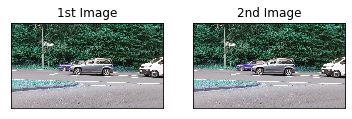

In [64]:
file1path = '/Users/pawnesh/Downloads/temporary/VID-20200610-153242/0002.jpg'
file2path = '/Users/pawnesh/Downloads/temporary/VID-20200610-153242/0003.jpg'
frame1 = cv2.imread(file1path)
frame2 = cv2.imread(file2path)
gframe1 = cv2.imread(file1path, 0)
gframe2 = cv2.imread(file2path, 0)
gframe2.resize(gframe1.shape[0], gframe1.shape[1])
U, V = HornSchunk(smoothing(gframe1, 2), smoothing(gframe2,2))

# U, V = optimal_vector(U, V, threshold=50)
plt.subplot(121),plt.imshow(frame1, cmap = 'gray')
plt.title('1st Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(frame2, cmap = 'gray')
plt.title('2nd Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [65]:
def show_optical_flow(U,V):
    l,c = U.shape;
    d = 5; # step
    IndX = range(1,l,d);
    IndY = range(1,c,d);
    [X,Y] = np.meshgrid(IndY, IndX);
    U1 = U[1:l:d, 2:c:d]
    V1 = V[1:l:d, 2:c:d]

    fig, ax = plt.subplots(figsize=(40,20))
    ax.quiver(X, Y, U1[-1:1:-1,:],V1[-1:1:-1,:], color="gray")
#     ax.plot(X, Y, )
    plt.show()

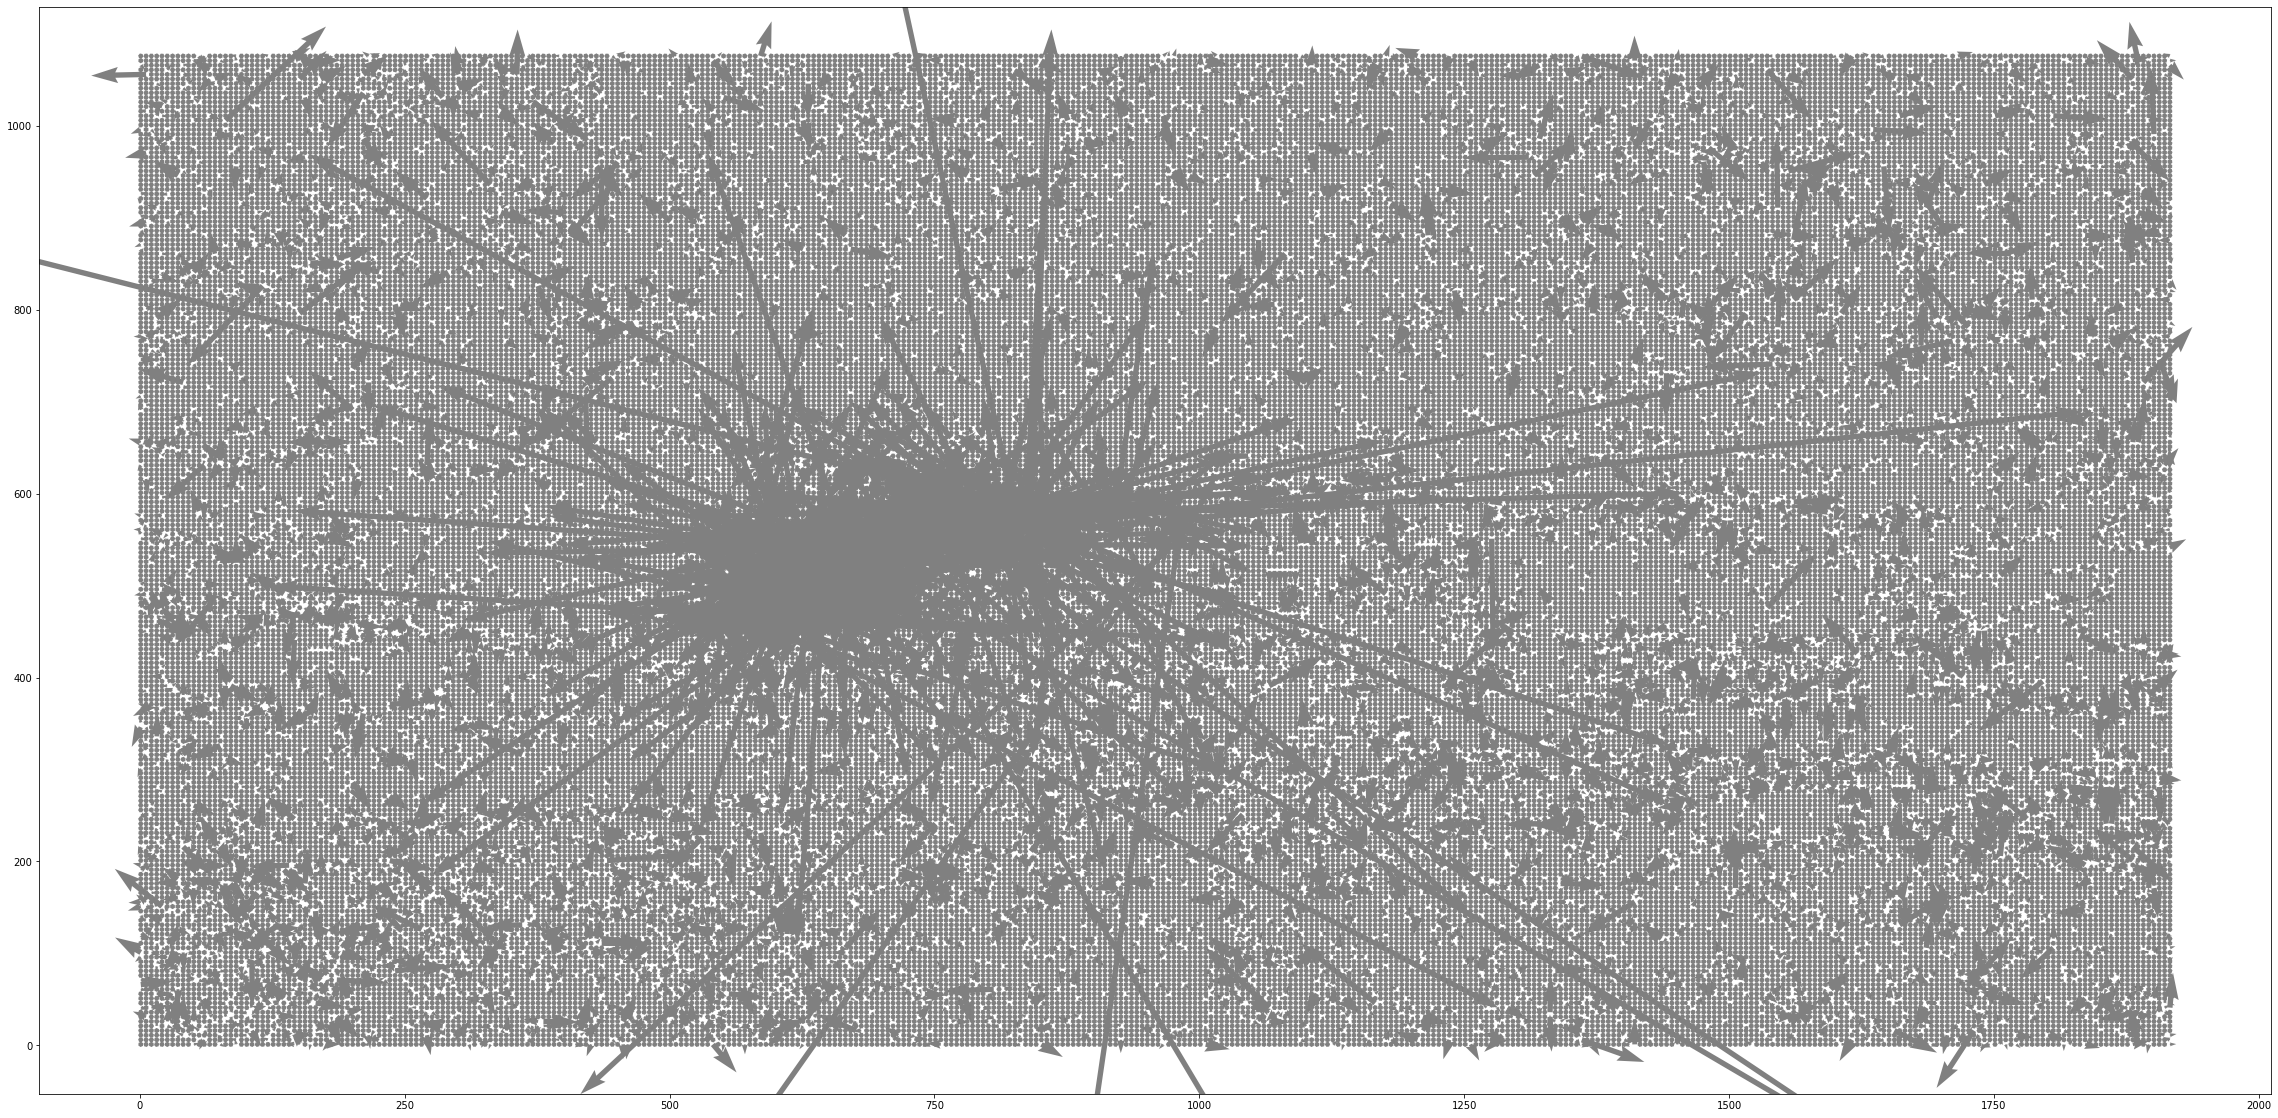

In [66]:

show_optical_flow(U, V)


In [67]:
# https://stackoverflow.com/questions/41661517/drawing-results-of-calcopticalflowfarneback-in-opencv-without-loop

def drawOpticalflow(img, U,V, step=7):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    
    flow = np.dstack((U,V))
  
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.2)
    color = (255, 0, 0) 
    thickness = 2
    cv2.polylines(img, lines, 0, color, thickness)

    plt.figure(figsize=(40,20))
    plt.imshow(img, cmap='gray')
    plt.title('optical flow'), plt.xticks([]), plt.yticks([])
#     cv2.imshow('Horn schrunk algo', vis)
#     cv2.waitKey(0)  
  
#     #closing all open windows  
#     cv2.destroyAllWindows()

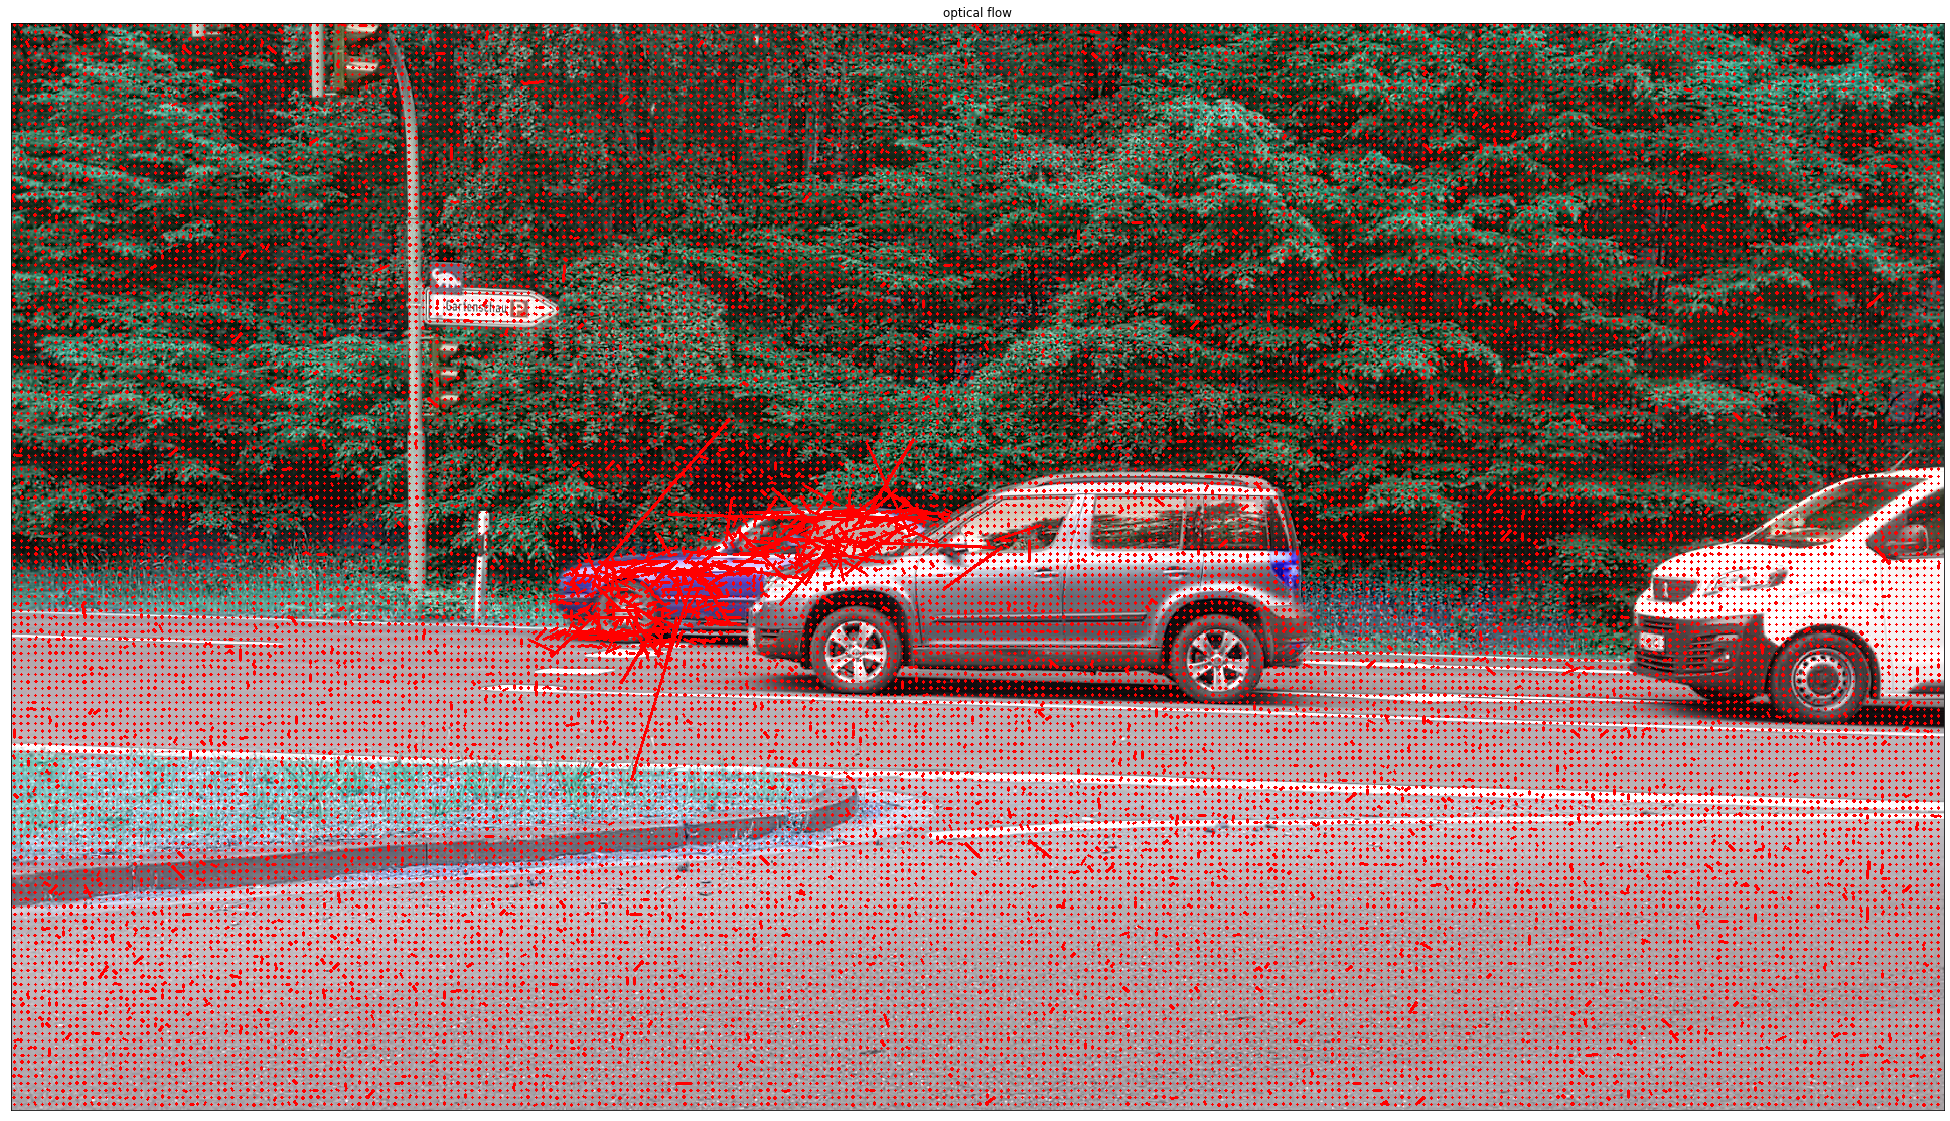

In [68]:
drawOpticalflow(frame2, U, V)

## References 
1.Berthold K.P. Horn and Brian G. Rhunck  "Determining optical flow" AIL MIT, 
2. ferrari frames "https://www.youtube.com/watch?v=hekNVtAZDgU&t=11s"
3. Opencv Doc: https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html
4. UCF Computer Vision Video Lectures 2012
https://www.youtube.com/watch?v=5VyLAH8BhF8&list=RDCMUClOghZ_xkI1km31IeoY-9Bw&index=6

In [7]:
gframe1


array([[ 95, 150, 179, ...,  41,  44,  66],
       [ 97, 148, 161, ...,  41,  43,  66],
       [ 99, 148, 147, ...,  39,  41,  65],
       ...,
       [130, 147, 168, ...,  87,  87,  89],
       [143, 156, 175, ...,  81,  81,  82],
       [160, 167, 179, ...,  81,  81,  81]], dtype=uint8)